In [1]:
import numpy as np
import pandas as pd
import keras
# from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
import seaborn as sns 
from os import makedirs
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import load_model
from numpy import dstack

# from sklearn.ensemble import RandomForestRegressor

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate


In [2]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabular_2021_Jan/train.csv', index_col='id')
sub_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabular_2021_Jan/test.csv', index_col='id')
submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabular_2021_Jan/sample_submission.csv', index_col='id')
print(data_df.shape, sub_df.shape)
data_df[:2]

(300000, 15) (200000, 14)


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
id,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331


In [3]:
data_target = data_df.pop('target')

In [4]:
n_train = data_df.shape[0] // 10
n_valid = data_df.shape[0] // 10

X_train, y_train = data_df[:n_train], data_target[:n_train]
X_test, y_test = data_df[n_train:(data_df.shape[0]-n_valid)], data_target[n_train:(data_df.shape[0]-n_valid)]
# usually this is not 'validation data', but I want to use it to test 'stacked model'
X_valid, y_valid = data_df[-n_valid:], data_target[-n_valid:]

## data visual

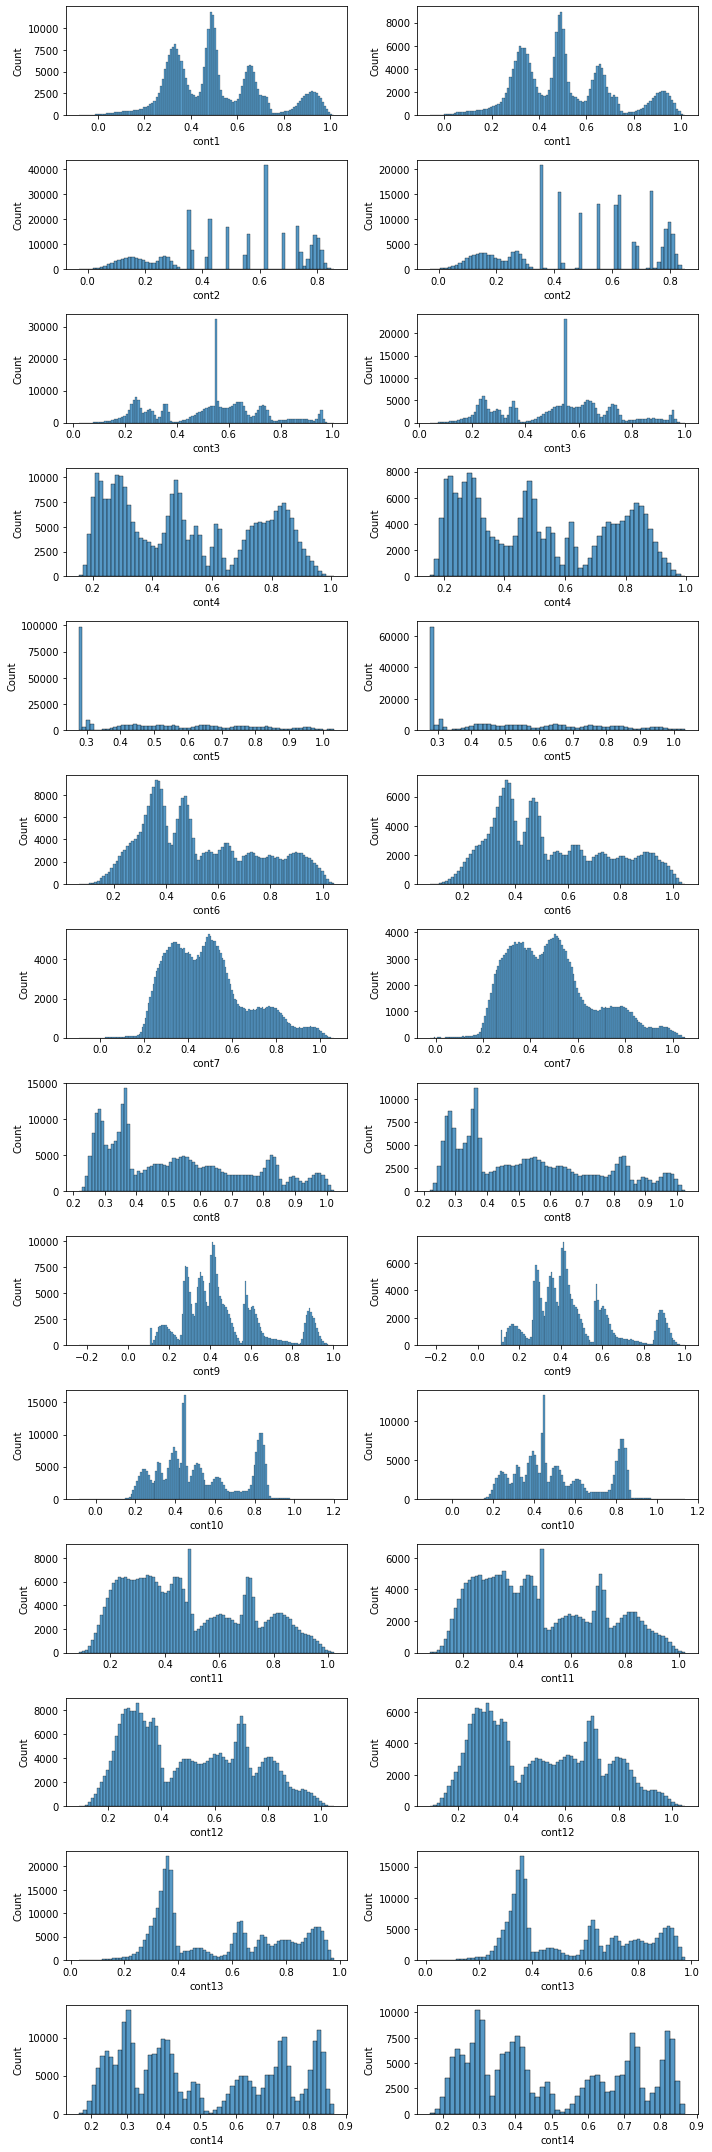

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(14, 2, figsize=(10, 30))

for i in range(1, 15):

  sns.histplot(data_df['cont'+str(i)], ax=ax[i-1][0])
  sns.histplot(sub_df['cont'+str(i)], ax=ax[i-1][1])
fig.tight_layout()
plt.savefig('data.png')

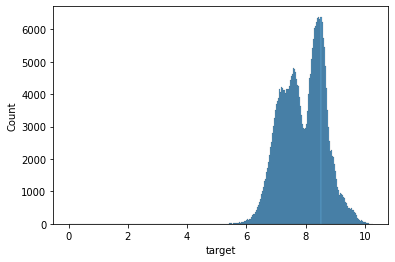

In [6]:
sns.histplot(data_target)

# data preprocessing

In [7]:
from sklearn.preprocessing import Normalizer, KBinsDiscretizer
from sklearn.decomposition import PCA
def preprocessing(data):
  pca = PCA(n_components=0.8, svd_solver='full')
  scaler = Normalizer()
  # data = pca.fit_transform(data)
  # data = scaler.fit_transform(data)
  
  # est = KBinsDiscretizer(
  #     n_bins=10,
  #     encode='ordinal',
  #     strategy='kmeans'
  # )
  # data = est.fit_transform(data)
  return data
preprocessing(X_train)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
id,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484
4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047
5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528
8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49690,0.257979,0.737074,0.531459,0.805689,0.440576,0.375699,0.966327,0.546981,0.360548,0.832800,0.428543,0.807083,0.336831,0.580132
49692,0.955282,0.181632,0.241572,0.627373,0.320519,0.911803,0.480436,0.834425,0.874279,0.823478,0.575884,0.576854,0.952762,0.851120
49694,0.733869,0.279350,0.158140,0.264932,0.293309,0.622202,0.584085,0.332349,0.429375,0.567979,0.445006,0.482618,0.743944,0.381783


# Single DNN model

In [8]:
# define model
model = Sequential()
model.add(Dense(
    units=25,
    input_shape=(X_train.shape[1],),
    activation='relu',
))
model.add(Dense(
    units=1,
    activation='relu'
))
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [9]:
# fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=2048,
    epochs=1000,
    verbose=0
)

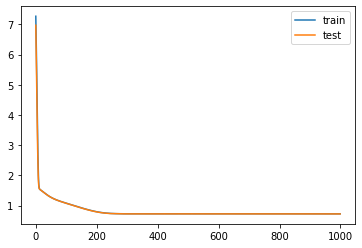

In [10]:
train_mse, train_rmse = model.evaluate(X_train, y_train, verbose=0)
test_mse, test_rmse = model.evaluate(X_test, y_test, verbose=0)
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

In [11]:
print(test_rmse)

0.7251874804496765


# Train and Save Sub-Models

### define sub-models

In [12]:
def build_model_1():  # 32X32X32X1
  model = Sequential()
  model.add(Dense(
      units=32,
      kernel_initializer='normal',
      input_shape=(preprocessing(X_train).shape[1],),
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=32,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=32,
      kernel_initializer='normal',
      activation='relu'
  ))
  model.add(Dense(
      units=1,
      activation='relu'
  ))
  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=[keras.metrics.RootMeanSquaredError()]
  )
  return model
def build_model_2():  # 256X256X128X1
  model = Sequential()
  model.add(Dense(
      units=256,
      kernel_initializer='normal',
      input_shape=(preprocessing(X_train).shape[1],),
      activation='relu'
  ))
  model.add(Dropout(0.5))
  model.add(Dense(
      units=256,
      kernel_initializer='normal',
      activation='relu'
  ))
  model.add(Dropout(0.5))
  model.add(Dense(
      units=128,
      kernel_initializer='normal',
      activation='relu'
  ))
  model.add(Dense(
      units=1,
      activation='relu'
  ))
  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=[keras.metrics.RootMeanSquaredError()]
  )
  return model
def build_model_3():  # 64X64X64X64X64X1
  model = Sequential()
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      input_shape=(preprocessing(X_train).shape[1],),
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=1,
      activation='relu'
  ))
  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=[keras.metrics.RootMeanSquaredError()]
  )
  return model
def build_model_4():  # 14X32X64X32X14X1
  model = Sequential()
  model.add(Dense(
      units=14,
      kernel_initializer='normal',
      input_shape=(preprocessing(X_train).shape[1],),
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=32,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=32,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=14,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=1,
      activation='relu'
  ))
  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=[keras.metrics.RootMeanSquaredError()]
  )
  return model
def build_model_5():  # 14X64X64X32X10X1
  model = Sequential()
  model.add(Dense(
      units=14,
      kernel_initializer='normal',
      input_shape=(preprocessing(X_train).shape[1],),
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=64,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=32,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=10,
      kernel_initializer='normal',
      activation='relu'
  ))
  # model.add(Dropout(0.5))
  model.add(Dense(
      units=1,
      activation='relu'
  ))
  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=[keras.metrics.RootMeanSquaredError()]
  )
  return model

In [13]:
# fit model
def fit_model(X, y):
  model.fit(
    X,
    y,
    epochs=200,
    batch_size=5000,
    verbose=0  
  )
  return model

In [14]:
# create directory for models
# if exist, need to delete 子資料夾如果存在需先刪除
makedirs('models')

n_members = 5
model1 = build_model_1()
model2 = build_model_2()
model3 = build_model_3()
model4 = build_model_4()
model5 = build_model_5()
model_list = [model1, model2, model3, model4, model5]
for i in range(n_members):
  model = model_list[i]
  # fit model
  model = fit_model(preprocessing(X_train), y_train)
  # save model
  filename = 'models/model_' + str(i + 1) + '.h5'
  model.save(filename)
  print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


# Separate Stacking Model

In [15]:
# load models from file
def load_all_models(n_models):
	all_models = []
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [16]:
n_members = 5
members = load_all_models(n_members)
print('Load %d model' % len(members)) 

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Load 5 model


In [17]:
# evaluate standalone models on test dataset
# 每個單獨模型對test data評估
for model in members:
	mse, rmse = model.evaluate(preprocessing(X_valid), y_valid, batch_size=5000, verbose=0)
	print('Model RMSE: %.5f' % rmse)

Model RMSE: 0.72562
Model RMSE: 0.72457
Model RMSE: 0.72597
Model RMSE: 7.93941
Model RMSE: 0.72881


# Let's train our meta-learner
This requires two steps:

* Prepare a training dataset for the meta-learner.
* Use the prepared training dataset to fit a meta-learner model.

In [18]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, X_input):
  X_stack = None
  for model in members:
    # make prediction
    yhat = model.predict(X_input, verbose=0)
    # stack predictions into [rows, members, yhat]
    if X_stack is None:
      X_stack = yhat
    else:
      # use np.dstack
      X_stack = dstack((X_stack, yhat))
    # flatten predictions to [rows, members * yhat]
  X_stack = X_stack.reshape((X_stack.shape[0], X_stack.shape[1]*X_stack.shape[2]))
  return X_stack

In [19]:
# fit a model based on the outputs from the ensemble members

def fit_stacked_model(members, X_input, y_input):
  # creat dataset using ensemble
  X_stacked = stacked_dataset(members, X_input)
  # fit standalone model 擬和每個模型
  model = LinearRegression()
  # model = RandomForestRegressor()
  model.fit(X_stacked, y_input)
  return model

In [20]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, y_test)


In [21]:
# make a prediction with the stacked model
def stacked_prediction(members, model, X_input):
	# create dataset using ensemble
	X_stacked = stacked_dataset(members, X_input)
	# make a prediction
	yhat = model.predict(X_stacked)
	return yhat

In [22]:
# test on new data, we can demonstrate it by making predictions on the test set.
yhat = stacked_prediction(members, model, (X_valid))
rmse = mean_squared_error(y_valid, yhat, squared=False)
print('Stacked test RMSE: %.5f' % rmse)

Stacked test RMSE: 0.72038


# Make a submission

In [23]:
def Submission(submission, target):
  submission['target'] = target
  submission.to_csv('Submission.csv')

target = stacked_prediction(members, model, sub_df)
Submission(submission_df, target)

# Integrated Stacking Model
#### When using neural networks as sub-models, it may be desirable to use a neural network as a meta-learner. 

#### Combine sub-models to a big DNN model(using the Keras functional interface for developing models.)

#### 如果用DNN當子模型，我們也可以將其合併到一個大個DNN模型，用"Keras functional interface"(from keras.models import Model)

In [24]:
# define stacked model from multiple member input models
def define_stacked_model(members):
  # update all layers in all models to not be trainable
  for i in range(len(members)):
     model = members[i]
     for layer in model.layers:
       # make not trainable
       layer.trainable = False
       # rename to avoid 'unique layer name' issue
       layer._name = 'ensemble_' + str(i) + '_' + layer.name
  # define multi-headed input 定義多頭的輸入
  ensemble_visible = [model.input for model in members]
  # concatenate merge output from each model 合併每個子模型的輸出
  ensemble_outputs = [model.output for model in members]
  merge = concatenate(ensemble_outputs)
  hidden_1 = Dense(300, activation='relu')(merge)
  hidden_2 = Dense(100, activation='relu')(hidden_1)
  output = Dense(1, activation='relu')(hidden_2)
  model = Model(inputs=ensemble_visible, outputs=output)
  # plot gragh of ensemble
  plot_model(model, show_shapes=True, to_file='model_graph.png')
  # compile
  model.compile(
      loss='mse',
      optimizer='adam',
      metrics=[keras.metrics.RootMeanSquaredError()]
  )
  return model

In [25]:
stacked_model = define_stacked_model(members)

In [26]:
# fit a stacked model
def fit_DNN_stacked_model(model, X_input, y_input):
  # prepare X_input data 集成模型的輸入需要五個子模型的輸入
  X = [X_input for _ in range(len(model.input))]
  # fit model
  model.fit(
    X,
    y_input,
    epochs=100,
    batch_size=5000,
    verbose=1
  )

In [27]:
fit_DNN_stacked_model(stacked_model, X_test, y_test)

Epoch 1/100
48/48 [==============================] - 5s 83ms/step - loss: 63.0766 - root_mean_squared_error: 7.9421
Epoch 2/100
48/48 [==============================] - 4s 83ms/step - loss: 63.0179 - root_mean_squared_error: 7.9384
Epoch 3/100
48/48 [==============================] - 4s 82ms/step - loss: 63.0229 - root_mean_squared_error: 7.9387
Epoch 4/100
48/48 [==============================] - 4s 83ms/step - loss: 63.0187 - root_mean_squared_error: 7.9384
Epoch 5/100
48/48 [==============================] - 4s 84ms/step - loss: 63.0276 - root_mean_squared_error: 7.9390
Epoch 6/100
48/48 [==============================] - 4s 83ms/step - loss: 63.0609 - root_mean_squared_error: 7.9411
Epoch 7/100
48/48 [==============================] - 4s 83ms/step - loss: 63.0524 - root_mean_squared_error: 7.9406
Epoch 8/100
48/48 [==============================] - 4s 83ms/step - loss: 63.0332 - root_mean_squared_error: 7.9393
Epoch 9/100
48/48 [==============================] - 4s 84ms/step - loss

In [28]:
# make a prediction with a DNN stacked model
def predict_DNN_stacked_model(model, X_input):
  # prepare input data
  X = [X_input for _ in range(len(model.input))]
  # make prediction
  return model.predict(X, verbose=0)

In [29]:
yhat = predict_DNN_stacked_model(stacked_model, X_valid)
rmse = mean_squared_error(y_valid, yhat, squared=False)
print('Stacked test RMSE: %.5f' % rmse)

Stacked test RMSE: 7.93941


# Make a submission

In [30]:
target = predict_DNN_stacked_model(stacked_model, sub_df)
Submission(submission_df, target)